In [1]:
# import packages
import os
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
import gc
import pandas as pd
import seaborn as sns
from scipy.stats import linregress

In [2]:
# set up paths, directories, and variables for this specific dam
data_path = '/home/jovyan/repos/incubator_moraine_dam_analysis/data'
asc_burst = '012_023788_IW3'
des_burst = '048_101863_IW3'
asc_burst_path = f'{data_path}/data_igrams/{asc_burst}'
des_burst_path = f'{data_path}/data_igrams/{des_burst}'

dam_name = 'khar_tso'
proc_path = f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{dam_name}'

# define reference point, [y, x]
reference_point = [3093121.30, 605373.66]

# define crs 
crs = 32645

In [3]:
# read in dam polygon
dam_fn = f'../../mapping/polygons/{dam_name}_md.shp'
dam_gdf = gpd.read_file(dam_fn)
dam_gdf = dam_gdf.to_crs(crs) # reproject in case of mistake

# # load in moving area polygon
# moving_fn = f'../../mapping/polygons/{dam_name}_moving.shp'
# moving_gdf = gpd.read_file(moving_fn)

# pad dam bounds by 5 km 
padding = 5000
aoi_extent = [dam_gdf.bounds.minx.item()-padding,
               dam_gdf.bounds.maxy.item()+padding,
               dam_gdf.bounds.maxx.item()+padding,
               dam_gdf.bounds.miny.item()-padding]

In [4]:
asc_mintpy_path = 'asc_mintpy'
des_mintpy_path = 'des_mintpy'

In [5]:
# write velocity to geotiff

# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, engine='h5netcdf', phony_dims='sort')
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                          'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

# function to read time series into xarray
def mintpyTS_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, cache=False)
    ds = ds.rename_dims({'phony_dim_1':'time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    ds = ds.rename({'timeseries': 'displacement'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'time': ('time', pd.to_datetime(ds.date)),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop(['bperp', 'date'])
    ds = ds.rio.write_crs(crs)
    
    return ds

In [6]:
os.chdir(proc_path)
# read ascending and descending time series into xarray ds
asc_ts_fn = f'{asc_mintpy_path}/timeseries.h5'
asc_ts_ds = mintpyTS_to_xarray(asc_ts_fn, crs)
asc_ts_ds = asc_ts_ds.rename({'displacement': 'asc_displacement'})

des_ts_fn = f'{des_mintpy_path}/timeseries.h5'
des_ts_ds = mintpyTS_to_xarray(des_ts_fn, crs)
des_ts_ds = des_ts_ds.rename({'displacement': 'des_displacement'})

# read geometry files into xarray ds
asc_geom_fn = f'{asc_mintpy_path}/inputs/geometryGeo.h5'
des_geom_fn = f'{des_mintpy_path}/inputs/geometryGeo.h5'
asc_geom_ds = mintpy2d_to_xarray(asc_geom_fn, crs)
des_geom_ds = mintpy2d_to_xarray(des_geom_fn, crs)

/tmp/ipykernel_73258/1822251850.py:36: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['bperp', 'date'])
/tmp/ipykernel_73258/1822251850.py:36: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop(['bperp', 'date'])


In [7]:
# find shorter time series and interpolate
asc_tspan = asc_ts_ds.time[-1] - asc_ts_ds.time[0]
des_tspan = des_ts_ds.time[-1] - des_ts_ds.time[0]

if des_tspan > asc_tspan:
    ts_ds = asc_ts_ds.assign(des_displacement=des_ts_ds.interp(time=asc_ts_ds.time).des_displacement)
    ts_ds['des_displacement'] = ts_ds['des_displacement'] - ts_ds['des_displacement'].isel(time=0)
elif asc_tspan > des_tspan:
    ts_ds = des_ts_ds.assign(asc_displacement=asc_ts_ds.interp(time=des_ts_ds.time).asc_displacement)
    ts_ds['asc_displacement'] = ts_ds['asc_displacement'] - ts_ds['asc_displacement'].isel(time=0)

else:
    print('same time span, interpolate to ascending')
    ts_ds = asc_ts_ds.assign(des_displacement=des_ts_ds.interp(time=asc_ts_ds.time).des_displacement)
    ts_ds['des_displacement'] = ts_ds['des_displacement'] - ts_ds['des_displacement'].isel(time=0)

In [8]:
# define azimuth angle from sensor to target relative to north
asc_geom_ds['azimuthAngle'] =  90 - (asc_geom_ds['azimuthAngle'] - 90)
des_geom_ds['azimuthAngle'] = np.abs(des_geom_ds['azimuthAngle'] + 90) + 270

# construct unit look vectors 
asc_geom_ds['n_hat'] = np.cos(np.radians(asc_geom_ds.azimuthAngle))*np.sin(np.radians(asc_geom_ds.incidenceAngle))
asc_geom_ds['e_hat'] = np.sin(np.radians(asc_geom_ds.azimuthAngle))*np.sin(np.radians(asc_geom_ds.incidenceAngle))
asc_geom_ds['z_hat'] = np.cos(np.radians(asc_geom_ds.incidenceAngle))

des_geom_ds['n_hat'] = np.cos(np.radians(des_geom_ds.azimuthAngle))*np.sin(np.radians(des_geom_ds.incidenceAngle))
des_geom_ds['e_hat'] = np.sin(np.radians(des_geom_ds.azimuthAngle))*np.sin(np.radians(des_geom_ds.incidenceAngle))
des_geom_ds['z_hat'] = np.cos(np.radians(des_geom_ds.incidenceAngle))

# construct ud and ew unit vectors [n, e, d]
vertical_unit_vector = np.array([np.zeros_like(des_geom_ds['n_hat'].values), np.zeros_like(des_geom_ds['n_hat'].values), np.ones_like(des_geom_ds['n_hat'].values)])
horizontal_unit_vector = np.array([np.zeros_like(des_geom_ds['n_hat'].values), np.ones_like(des_geom_ds['n_hat'].values), np.zeros_like(des_geom_ds['n_hat'].values)])
# north
#horizontal_unit_vector = np.array([np.ones_like(des_geom_ds['n_hat'].values), np.zeros_like(des_geom_ds['n_hat'].values), np.zeros_like(des_geom_ds['n_hat'].values)])

In [9]:
# find dot products for LOS
asc_vertical = np.einsum('ijk,ijk->jk', np.array([asc_geom_ds['n_hat'].values, asc_geom_ds['e_hat'].values, asc_geom_ds['z_hat'].values]), vertical_unit_vector)
asc_horizontal = np.einsum('ijk,ijk->jk', np.array([asc_geom_ds['n_hat'].values, asc_geom_ds['e_hat'].values, asc_geom_ds['z_hat'].values]), horizontal_unit_vector)
des_vertical = np.einsum('ijk,ijk->jk', np.array([des_geom_ds['n_hat'].values, des_geom_ds['e_hat'].values, des_geom_ds['z_hat'].values]), vertical_unit_vector)
des_horizontal = np.einsum('ijk,ijk->jk', np.array([des_geom_ds['n_hat'].values, des_geom_ds['e_hat'].values, des_geom_ds['z_hat'].values]), horizontal_unit_vector)

In [10]:
# solve for horizontal and vertical displacement for all dates 
ts_ds['vertical_displacement'] = (asc_horizontal*ts_ds.des_displacement - des_horizontal*ts_ds.asc_displacement)/(asc_horizontal*des_vertical - des_horizontal*asc_vertical)
ts_ds['horizontal_displacement'] = ((asc_vertical*ts_ds['vertical_displacement']) - ts_ds.asc_displacement)/-asc_horizontal

In [11]:
decimal_years = ((ts_ds['time'] - np.datetime64('1970-01-01T00:00:00'))/np.timedelta64(1, 'ns')/1e9/3600/24/365.25)+1970
ts_ds = ts_ds.assign_coords(decimal_year = ('time', decimal_years.data))

In [12]:
# Function to fit a line to a 1D array and return the slope
def fit_line(x, y):
    valid_indices = ~np.isnan(y)
    try: 
        slope, _, _, _, _ = linregress(x[valid_indices], y[valid_indices])
    except: 
        return np.nan
    else:
        return slope

In [13]:
vertical_veloc = xr.apply_ufunc(fit_line, ts_ds.decimal_year, ts_ds.vertical_displacement, input_core_dims=[['time'], ['time']], vectorize=True)
horizontal_veloc = xr.apply_ufunc(fit_line, ts_ds.decimal_year, ts_ds.horizontal_displacement, input_core_dims=[['time'], ['time']], vectorize=True)

In [14]:
# write to rasters
vertical_veloc = vertical_veloc.rio.write_crs(crs)
vertical_veloc.rio.to_raster(f'vertical_velocity_{dam_name}.tif')
horizontal_veloc = horizontal_veloc.rio.write_crs(crs)
horizontal_veloc.rio.to_raster(f'ew_velocity_{dam_name}.tif')

In [15]:
# load in moving area polygon
moving_fn = f'../../mapping/polygons/{dam_name}_moving.shp'
moving_gdf = gpd.read_file(moving_fn)

In [16]:
# load in moving area polygon
water_fn = f'../../mapping/polygons/water_mask.shp'
water_gdf = gpd.read_file(water_fn)

In [17]:
# other stuff! 
# load in moving area polygon
moving_fn = f'../../mapping/polygons/{dam_name}_md_north_bank.shp'
moving_gdf = gpd.read_file(moving_fn)

In [18]:
moving_ts = ts_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs, drop=True)

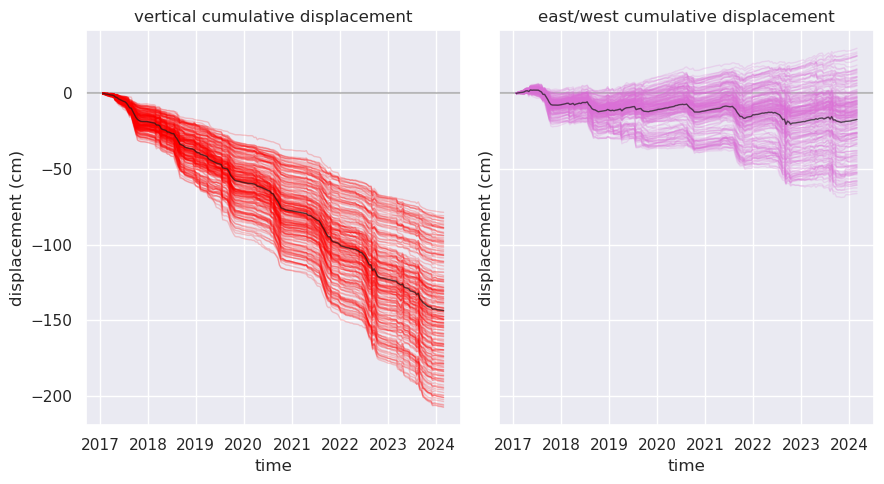

In [19]:
sns.set_theme()
f, ax = plt.subplots(1, 2, figsize=(9,5), sharex=True, sharey=True)
ax[0].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts.x)):
    for y in range(len(moving_ts.y)):
        if (x+1) % 1 + (y+1) % 1 == 0:
            (moving_ts.vertical_displacement.isel(x=x, y=y)*100).plot(ax=ax[0], c='red', linewidth=1, alpha=0.2)
(moving_ts.vertical_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax[0], c='k', linewidth=1, alpha=0.7)

ax[1].axhline(y=0, c='gray', alpha=0.5)
for x in range(len(moving_ts.x)):
    for y in range(len(moving_ts.y)):
        if (x+1) % 1 + (y+1) % 1 == 0:
            (moving_ts.horizontal_displacement.isel(x=x, y=y)*100).plot(ax=ax[1], c='orchid', linewidth=1, alpha=0.2)
(moving_ts.horizontal_displacement.mean(dim=('x', 'y'))*100).plot(ax=ax[1], c='k', linewidth=1, alpha=0.7)

ax[0].set_title('vertical cumulative displacement')
ax[0].set_ylabel('displacement (cm)')
ax[1].set_title('east/west cumulative displacement')
ax[1].set_ylabel('displacement (cm)')
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_decomp_pixels_ts.png', dpi=300)

In [20]:
moving_ts_weekly = moving_ts
moving_ts_weekly['vertical_velocity'] = moving_ts_weekly.vertical_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25
moving_ts_weekly['horizontal_velocity'] = moving_ts_weekly.horizontal_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25

In [21]:
moving_months = moving_ts_weekly.groupby(moving_ts_weekly.time.dt.month).median()

In [22]:
ones = xr.ones_like(moving_months.vertical_velocity)
months_broadcast = ones*moving_months.month

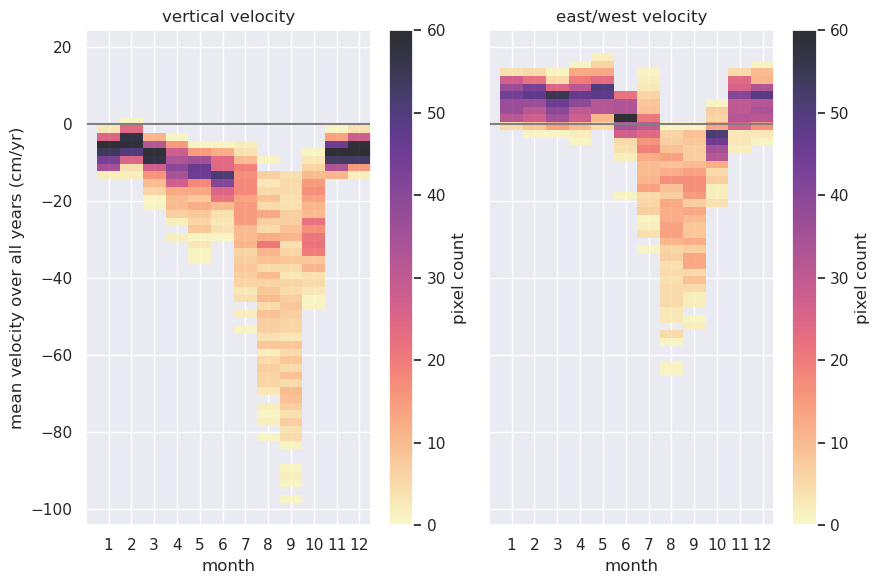

In [23]:
f, ax = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
ax[0].axhline(y=0, c='gray', alpha=1)
ax[1].axhline(y=0, c='gray', alpha=1)
sns.histplot(ax=ax[0], x=months_broadcast.values.flatten(), y = moving_months.vertical_velocity.values.flatten()*100, cbar=True, discrete=(True, False), binwidth=2, vmax=60, cmap='magma_r', alpha=0.8, cbar_kws={'label':'pixel count'})
sns.histplot(ax=ax[1], x=months_broadcast.values.flatten(), y = moving_months.horizontal_velocity.values.flatten()*100, cbar=True, discrete=(True, False), binwidth=2, vmax=60, cmap='magma_r', alpha=0.8, cbar_kws={'label':'pixel count'})
ax[0].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[0].set_xlim(0, 12.5)
ax[1].set_xlim(0, 12.5)
ax[0].set_ylabel('mean velocity over all years (cm/yr)')
ax[0].set_xlabel('month')
ax[1].set_xlabel('month')
ax[0].set_title('vertical velocity')
ax[1].set_title('east/west velocity')
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_velocity.png', dpi=300)

In [24]:
# repeat interpolation and grouping with all pixels
# moving_ts_weekly_allpix = ts_ds.resample(time='2W').interpolate('linear')
moving_ts_weekly_allpix = ts_ds
moving_ts_weekly_allpix['vertical_velocity'] = moving_ts_weekly_allpix.vertical_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25
moving_ts_weekly_allpix['horizontal_velocity'] = moving_ts_weekly_allpix.horizontal_displacement.differentiate(coord='time', edge_order=1, datetime_unit='D')*365.25
moving_months_allpix = moving_ts_weekly_allpix.groupby(moving_ts_weekly_allpix.time.dt.month).median()

In [ ]:
# plot monthly velocity maps
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
f, axs = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
for i, month in enumerate(months):
    ax = axs[i % 4, i // 4]
    (moving_months_allpix.isel(month=i).vertical_velocity*100).plot(ax=ax, cmap='RdBu', vmin=-40, vmax=40, cbar_kwargs={'label':'vertical velocity (cm/yr)'})
    water_gdf.plot(ax=ax, edgecolor='none', facecolor='cadetblue')
    dam_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    ax.set_xlim(aoi_extent[0]+4900, aoi_extent[2]-4900)
    ax.set_ylim(aoi_extent[3]+4900, aoi_extent[1]-4900)
    ax.set_title(month, fontsize=30)
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_vertical_velocity_maps.png', dpi=300)

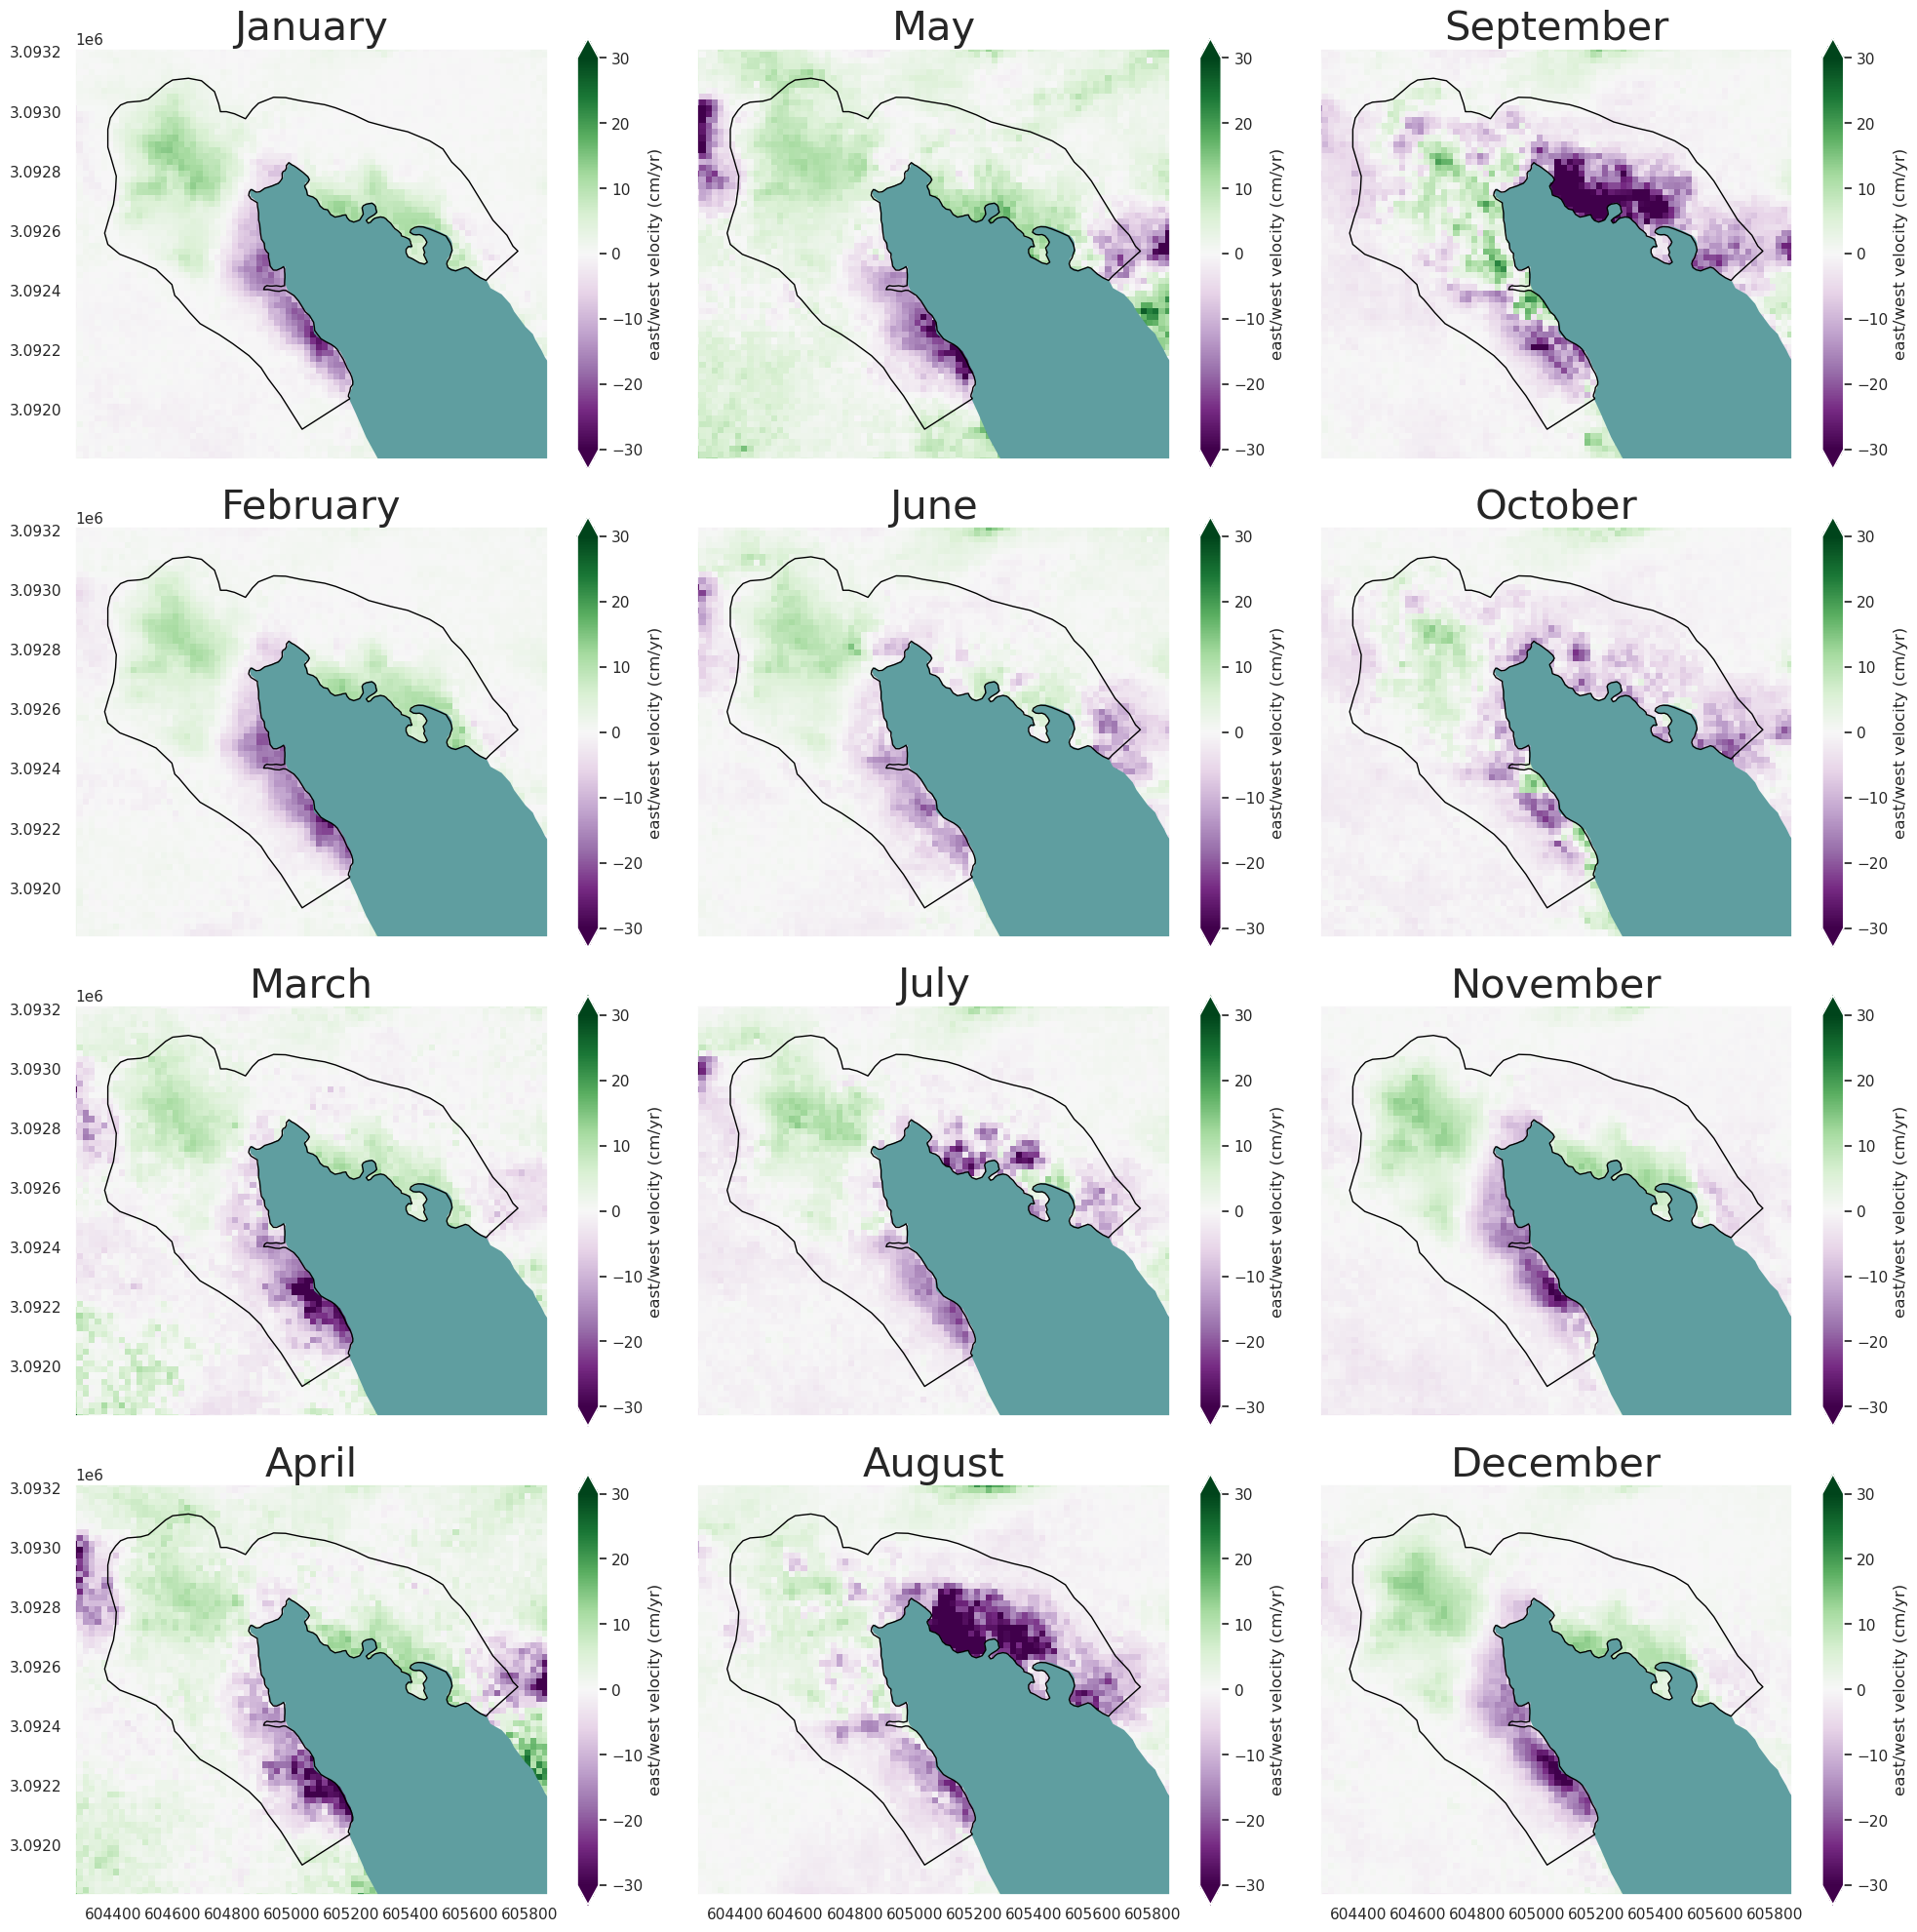

In [28]:
# plot monthly velocity maps
f, axs = plt.subplots(4, 3, figsize=(20, 20), sharex=True, sharey=True)
for i, month in enumerate(months):
    ax = axs[i % 4, i // 4]
    (moving_months_allpix.isel(month=i).horizontal_velocity*100).plot(ax=ax, cmap='PRGn', vmin=-30, vmax=30, cbar_kwargs={'label':'east/west velocity (cm/yr)'})
    water_gdf.plot(ax=ax, edgecolor='none', facecolor='cadetblue')
    dam_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    ax.set_xlim(aoi_extent[0]+4900, aoi_extent[2]-4900)
    ax.set_ylim(aoi_extent[3]+4900, aoi_extent[1]-4900)
    ax.set_title(month, fontsize=30)
    ax.set_aspect('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
f.tight_layout()
plt.savefig(f'./figs/{dam_name}_ew_velocity_maps.png', dpi=300)